In [344]:
import io, os, sys, types
import pprint
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import(
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
    GridSearchCV
)


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import(
    train_test_split,
    cross_val_score,
)

from sklearn.linear_model import(
    LassoCV,
    ElasticNetCV,
    LinearRegression
)

from sklearn.feature_selection import(
    f_regression,
    SelectKBest,
)

from sklearn.ensemble import(
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor
)

from sklearn.metrics import(
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score
)

from scipy.stats import skew

import pickle
import xgboost
from sklearn.externals import joblib

In [341]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Initializing the dataset
We'll want to apply the same transformations we make on train to test, that way, running a test model won't require going back to make changes to the data. To do this, we'll join the two dataframes.

In [280]:
data = pd.concat(objs=[train, test], axis=0)

# Visualizing Missingness
We'll use a useful tool from the missingno libary to graph NA values. 

UnboundLocalError: local variable 'ax2' referenced before assignment

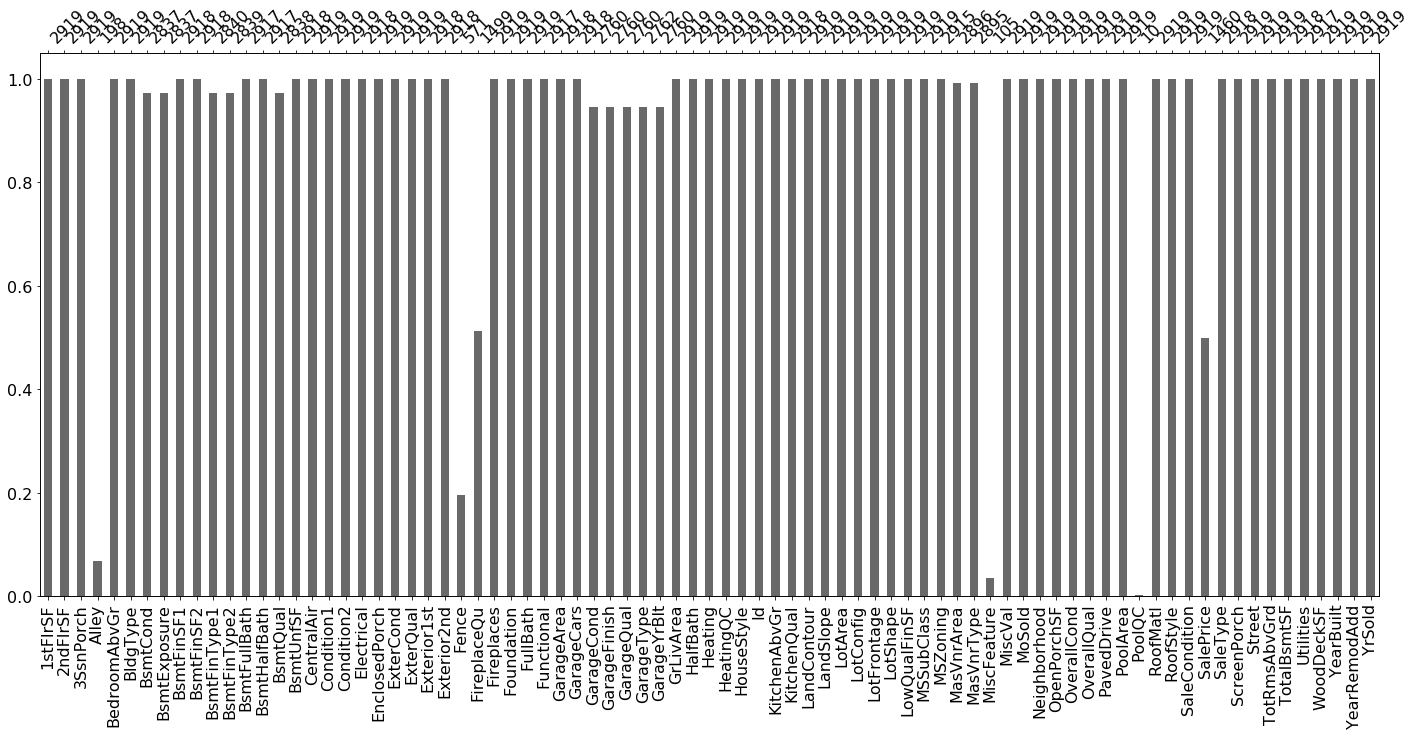

In [29]:
msno.bar(data)

The reason for Nan values can vary from column to column. Understanding this will help with imputation.

In [25]:
def return_nas(df):
    return df.columns[df.isnull().any()]
with_nas = return_nas(data)
print("Columns with missing values:\n {}".format(with_nas))
data[with_nas].head()

Columns with missing values:
 Index(['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'Electrical', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Functional', 'GarageArea', 'GarageCars',
       'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt',
       'KitchenQual', 'LotFrontage', 'MSZoning', 'MasVnrArea', 'MasVnrType',
       'MiscFeature', 'PoolQC', 'SalePrice', 'SaleType', 'TotalBsmtSF',
       'Utilities'],
      dtype='object')


,Alley,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,LotFrontage,MSZoning,MasVnrArea,MasVnrType,MiscFeature,PoolQC,SalePrice,SaleType,TotalBsmtSF,Utilities
0,NaN,TA,No,706.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,65.0,RL,196.0,BrkFace,NaN,NaN,208500.0,WD,856.0,AllPub
1,NaN,TA,Gd,978.0,0.0,ALQ,Unf,0.0,1.0,Gd,...,80.0,RL,0.0,None,NaN,NaN,181500.0,WD,1262.0,AllPub
2,NaN,TA,Mn,486.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,68.0,RL,162.0,BrkFace,NaN,NaN,223500.0,WD,920.0,AllPub
3,NaN,Gd,No,216.0,0.0,ALQ,Unf,1.0,0.0,TA,...,60.0,RL,0.0,None,NaN,NaN,140000.0,WD,756.0,AllPub
4,NaN,TA,Av,655.0,0.0,GLQ,Unf,1.0,0.0,Gd,...,84.0,RL,350.0,BrkFace,NaN,NaN,250000.0,WD,1145.0,AllPub


Some of the columns can have their NA values be converted to 0, an average/median/mode, or a category: "None".  
With others, we can try to get a little clever by looking into the data description.

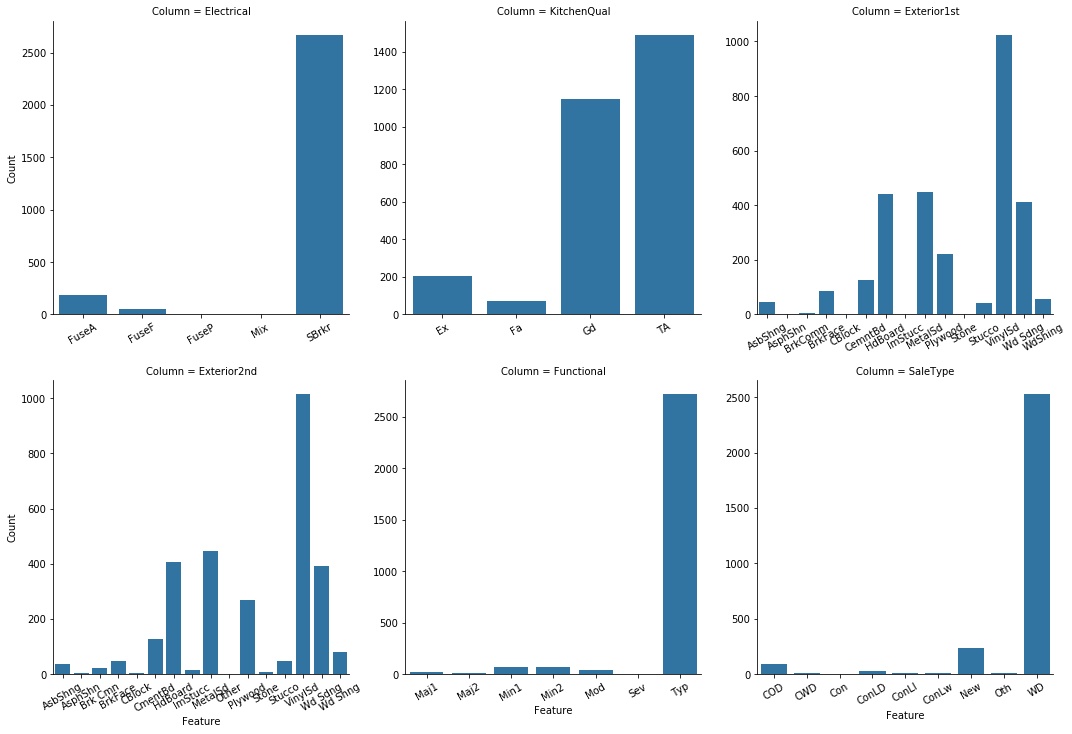

In [151]:
to_mode = [
    "Electrical", "KitchenQual", "Exterior1st",
    "Exterior2nd", "Functional", "SaleType"
]
P = pd.Series()
for i in range(len(to_mode)):
    df = pd.DataFrame(data.groupby(to_mode[i]).size())
    df["Column"] = str(to_mode[i])
    P = pd.concat([P, df], axis=0)
P.reset_index(inplace=True)
P.rename(index=str, columns={"index":"Feature", 0:"Count"}, inplace=True)

g = sns.FacetGrid(P, col="Column", col_wrap = 3, size = 5, sharex=False , sharey=False)
g = g.map(sns.barplot, "Feature", "Count", data=P)
g.fig.tight_layout(h_pad=3.5)
# Label rotation
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(30)

The mode values seem like good guesses for NA values, considering the mode is the overwhelming majority in these features.

In [281]:
to_None = [
    "Alley","BsmtCond", "BsmtExposure",
    "MiscFeature", "PoolQC","Fence",
    "FireplaceQu", "BsmtQual"]
data[to_None].fillna("None", inplace=True)

to_0 = [
    "MasVnrArea", "GarageYrBlt", "GarageArea",
    "GarageCars"]
data[to_0].fillna(0, inplace=True)

# Convert certain na's to their node values
for col in to_mode:
    data[col] = data[col].fillna(data[col].mode()[0])
    
# Some of the features are numerical, but their real value
#is in their distinctness from each other- so we can
#convert these features to "categorical".    
to_category = [
    "MSSubClass", "OverallCond", "YrSold",
    "MoSold", "OverallQual"
]
for col in to_category:
    data[col] = data[col].astype("str")
    
# Missing GarageYrBlt will have the same year the house was built
data['GarageYrBlt'].fillna(data['YearBuilt'], inplace=True)
# Median lot frontage by neighborhood
data["LotFrontage"].fillna(data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())), inplace=True)

# More Transformation

## Detecting outliers
With use of a scatter plot, we can find outliers that won't be helpful for training our model.  
Note: This step is easier to perform before applying any normalization to the data.

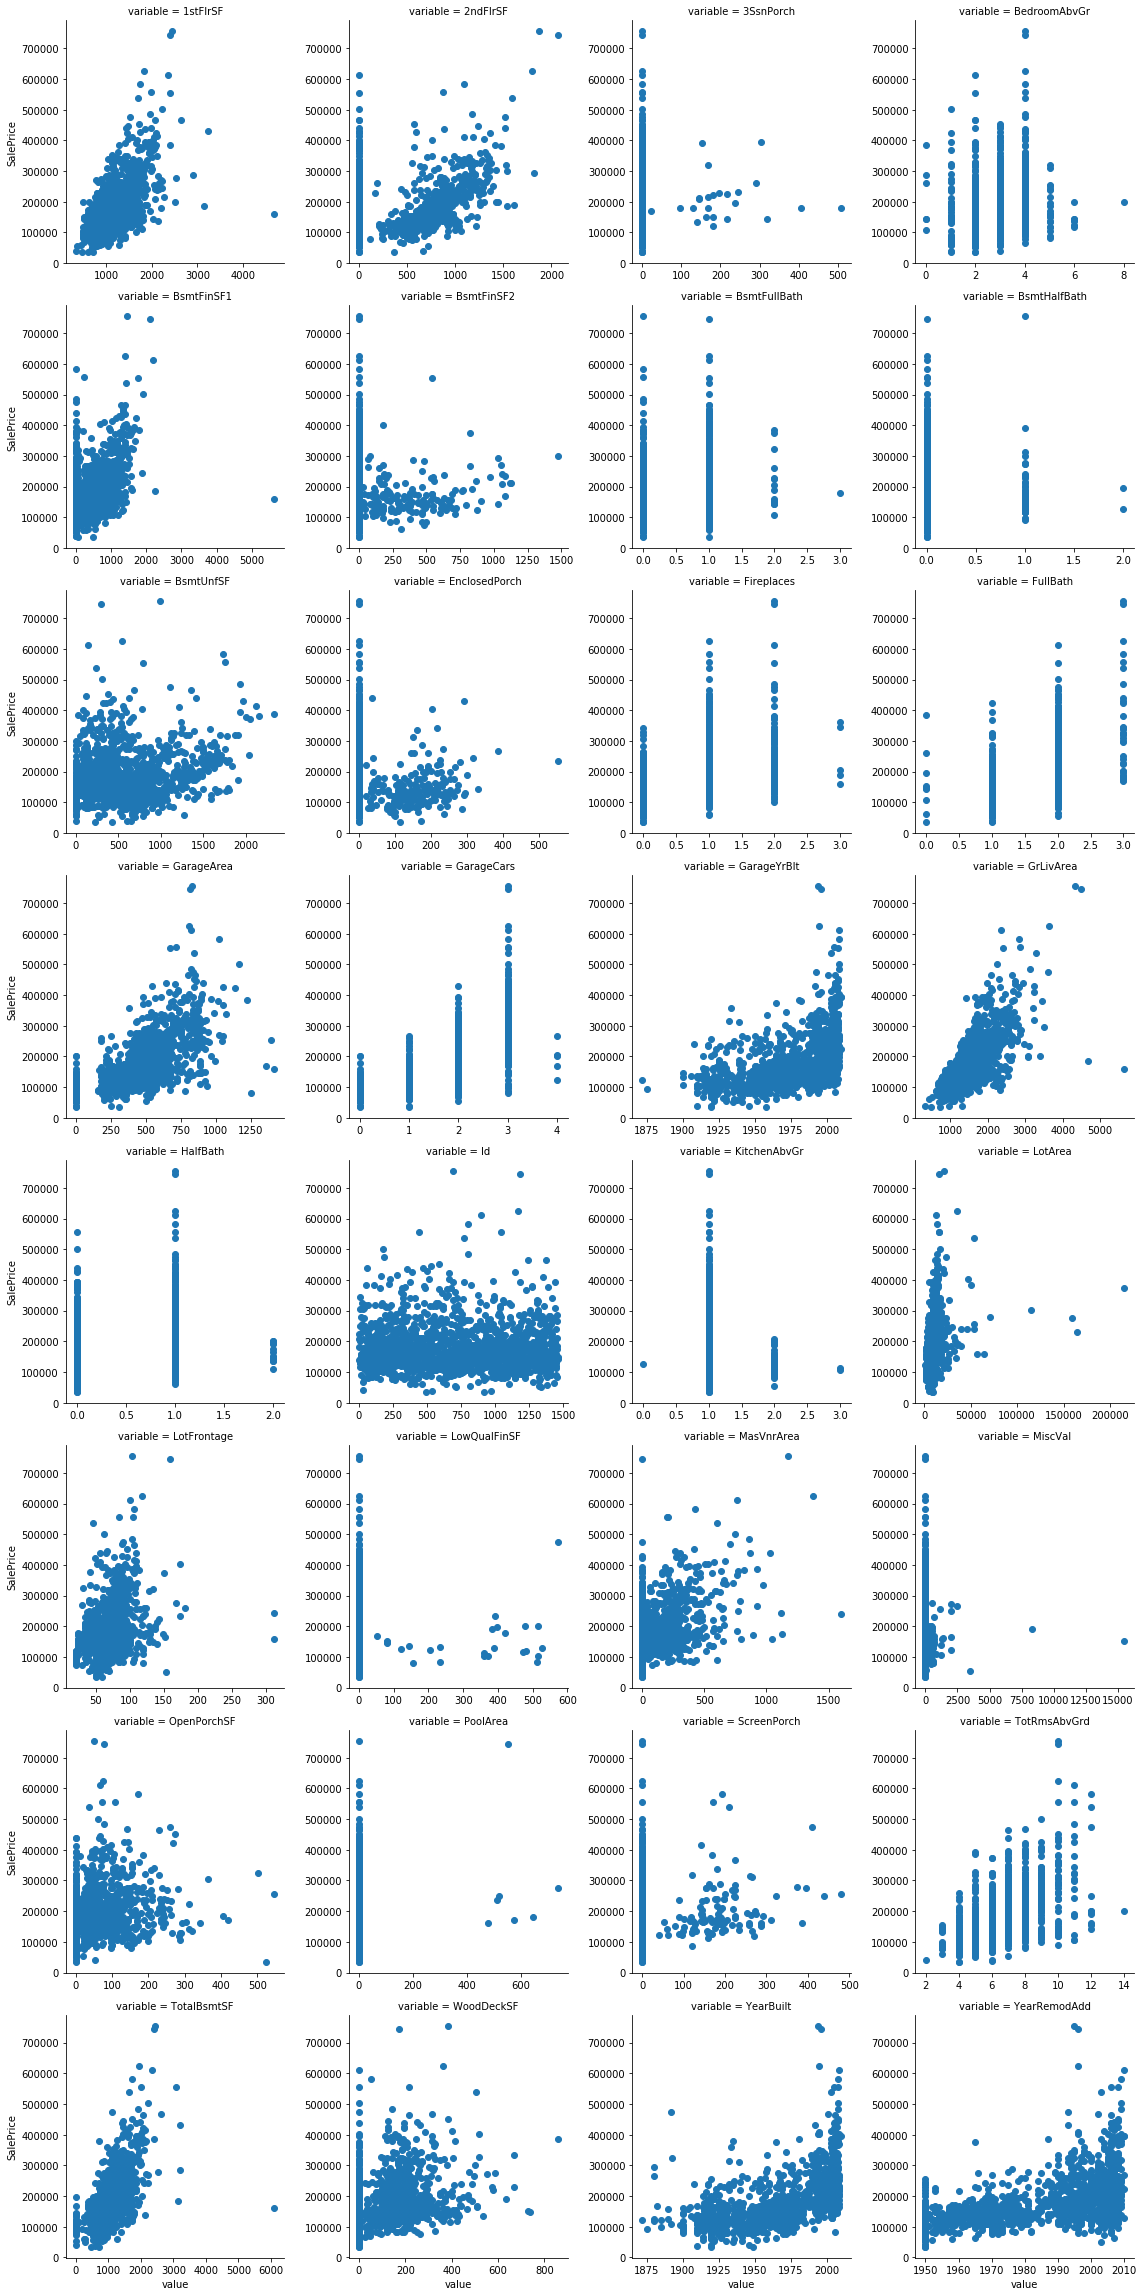

In [271]:
# We'll switch back to the original train dataframe for this visualization
tr = data[data["SalePrice"].isnull() == False]
y = tr["SalePrice"]
tr = tr.select_dtypes(include=['float64', "int64"])
tr.drop("SalePrice", axis=1, inplace=True)

f = pd.melt(pd.concat([tr,y],axis=1) , id_vars = ['SalePrice'] , value_vars = tr.columns )
g = sns.FacetGrid(f, col = 'variable' , col_wrap = 4, size = 4,sharex=False , sharey=False)
g = g.map(plt.scatter, "value", "SalePrice")

In [276]:
data = data.drop(data[(data["GrLivArea"] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['TotalBsmtSF'] > 5000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['MasVnrArea'] > 1500) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['BsmtFinSF1'] > 4000) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['LotFrontage'] > 250) & (data['SalePrice'] < 300000)].index)
data = data.drop(data[(data['OpenPorchSF'] > 400) & (data['SalePrice'] < 100000)].index)
data = data.drop(data[(data['1stFlrSF'] > 4000) & (data['SalePrice'] < 200000)].index)

We can check for skewed distributions, and normalize them.

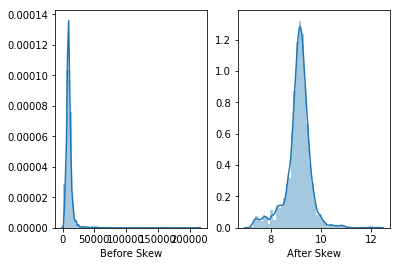

In [282]:
fig, axs = plt.subplots(ncols=2)
before_skew = data["LotArea"]

# Applying logarithmic transform to skewed features
# This code was pulled from Alexandru Papiu:
# https://www.kaggle.com/apapiu/regularized-linear-models

numeric_feats = data.dtypes[data.dtypes != "object"].index
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

log = lambda x: np.log1p(x)
data[skewed_feats] = data[skewed_feats].apply(log)
after_skew = data["LotArea"]
sns.distplot(before_skew, ax=axs[0], axlabel="Before Skew")
sns.distplot(after_skew, ax=axs[1], axlabel="After Skew")

# Dummy Variables and Feature Selection

In [342]:
y = train["SalePrice"]

In [343]:
train.drop("SalePrice", axis=1, inplace=True)

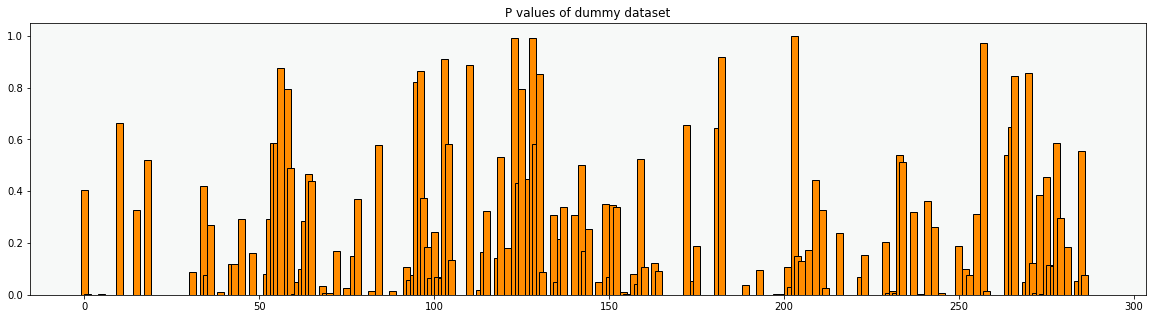

In [386]:
train = pd.get_dummies(train).fillna(0)
selector = SelectKBest(score_func=f_regression, k=10).fit(train, y)
scores = selector.pvalues_
scores /= scores.max()

X_indices = np.arange(train.shape[-1])
fig, ax = plt.subplots(figsize = (20,5))
plt.bar(X_indices, scores, width=2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')
ax.set_title("P values of dummy dataset")
ax.set_axis_bgcolor("#F7F9F8")

Many variables have very high P values, meaning there is little chance they have influence over the Sale Price of the house.

In [390]:
x = np.where(scores <= .05)
train = train[train.columns[x]]

In [391]:
### Correlation Plots
def corrgraphs(df):
    neg = df.corr()[df.corr() < -0.7]
    neg = neg.dropna(how="all", axis=1)
    neg = neg.dropna(how="all", axis=0)
    pos = df.corr()[df.corr() > 0.7]
    pos = pos[pos < 1.0]
    pos = pos.dropna(how="all", axis=1)
    pos = pos.dropna(how="all", axis=0)
    return (neg, pos)
neg, pos = corrgraphs(train)

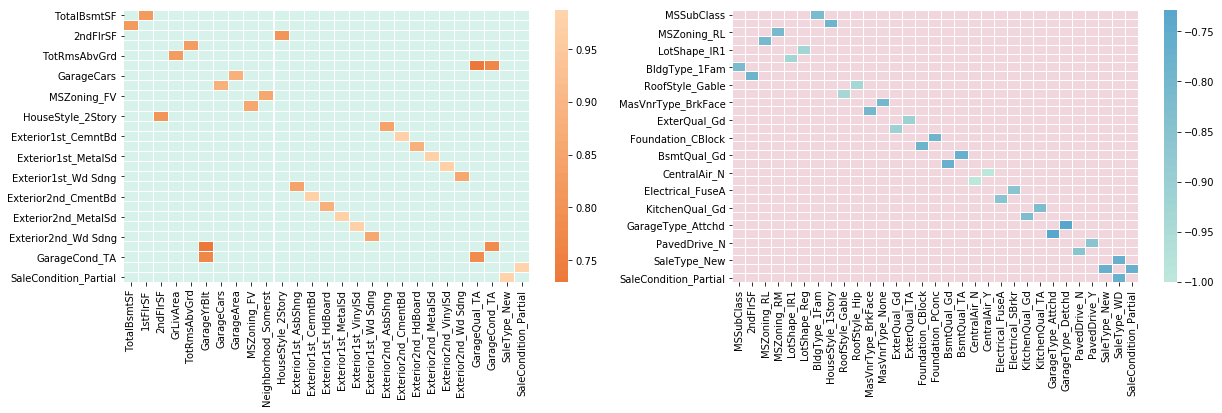

In [392]:
def plot_corrgraphs(neg, pos):
    fig, axs = plt.subplots(ncols=2, figsize=(20,5))
    pos_heatmap = sns.heatmap(pos, center=0, linewidths=0.01, ax=axs[0])
    pos_heatmap.set(axis_bgcolor="#D6F2EB")
    neg_heatmap = sns.heatmap(neg, center=0, linewidths=0.01, ax=axs[1])
    neg_heatmap.set(axis_bgcolor="#F2D6DD")
    return
plot_corrgraphs(neg, pos)

# Everything below here is not presentation ready!

In [915]:
# # Example plot
# regplot = sns.regplot(x = 'KitchenQual', y = 'SalePrice', data = df, color = '#FFB733')
# regplot.set(axis_bgcolor="#A2BFF4")

In [917]:
# plt.scatter(train_dummies["GrLivArea"], train_dummies["SalePrice"])

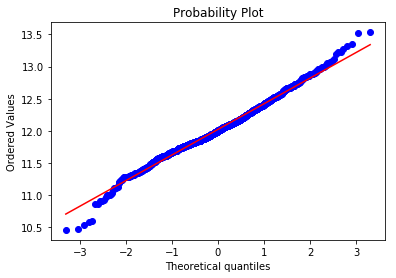

In [918]:
fig = plt.figure()
res = stats.probplot(train_dummies['SalePrice'], plot=plt)
plt.show()

In [1067]:
y = train_dummies["SalePrice"]
train_dummies_id = train_dummies["Id"]
train_dummies.drop(["SalePrice", "Id"], axis=1, inplace=True)

In [1070]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_filter(df):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["Features"] = df.columns
    return vif
vif = vif_filter(train_dummies)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [1104]:
# df = train_dummies[vif[vif["VIF Factor"] < 10]["features"]]
# vif
# vif["VIF Factor"] = round(vif["VIF Factor"])
# vif.groupby("VIF Factor").count()["features"] - 1

In [1073]:
# Full dataframe into Train-test Split
def full_set_split(df):
#     X = df.drop(["SalePrice","Id"], axis=1)
# #     X = vif_filter(X, thresh=5)
#     y = df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42)
    return (X_train, X_test, y_train, y_test)

In [1074]:
# df = unskew(train_dummies)
X_train, X_test, y_train, y_test = full_set_split(df)

In [1055]:
# X_test, X_test_stack = (X_test[:round(.5*len(X_test))], X_test[round(.5*len(X_test)):])
# y_test, y_test_stack = (y_test[:round(.5*len(y_test))], y_test[round(.5*len(y_test)):])

In [1087]:
dX_train, dX_test, dy_train, dy_test = full_set_split(train_dummies)

In [1057]:
# vif.sort_values(by="VIF Factor", ascending=False)

In [1116]:
from scipy.stats import stats

train = pd.read_csv("train.csv")
qual = [c for c in train.columns if train[c].dtype == 'object']    #qualitative variables

def annov(df , features):
    ann = pd.DataFrame()
    ann['feat'] = features
    pvals = []
    for col in features:
        var = []
        for val in df[col].unique():
            var.append(df[df[col] == val].SalePrice.values)
        pvals.append(stats.f_oneway(*var).pvalue)
    ann['pvals'] = pvals
    return ann

result = annov(train, qual)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


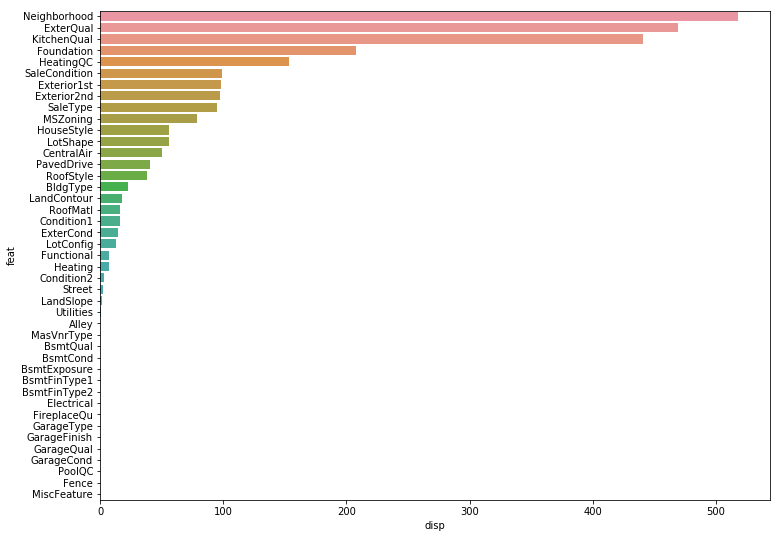

In [1119]:
# result.sort_values(by="pvals", ascending=True)
result['disp'] = np.log(1. / result['pvals'])
result = result.sort_values('disp' ,ascending = False)
plt.figure(figsize = (12,9))
sns.barplot(y = result['feat'] , x = result['disp'] ,orient = 'h')


# Modeling

In [1075]:
# Calculate RMSE
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [1076]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1077]:
print(rmse_cv(lm).mean())
print(lm.score(X_test, y_test))
lm_predict = lm.predict(X_test)

0.15913387392727824
0.8032137635241492


In [1085]:
dlm = LinearRegression()
dlm.fit(dX_train, dy_train)
dlm_predict = dlm.predict(dX_test)
# X_train["LM_Predict"] = lm_predict

In [874]:
# sns.regplot(train['TotalBsmtSF'], y=df["BsmtUnfSF"])

In [1078]:
# Lasso CV
model_lasso = LassoCV(normalize=True, cv=6).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
print(model_lasso.score(X_test, y_test))
model_lasso_predict = model_lasso.predict(X_test)

0.1506964974508314
0.8199477148982196


In [1088]:
dmodel_lasso = LassoCV(normalize=True, cv=6).fit(dX_train, dy_train)
dmodel_lasso_predict = dmodel_lasso.predict(dX_test)

In [1007]:
model_lasso_2 = LassoCV(normalize=True, cv=10, alphas=[0.0001]).fit(X_train, y_train)
print(rmse_cv(model_lasso_2).mean())
print(model_lasso_2.score(X_test, y_test))
model_lasso_predict = model_lasso_2.predict(X_test)

0.15266881892621634
0.8060460247226805


In [876]:
# model_lasso_predict_stack = model_lasso.predict(X_test_stack)

In [877]:
# preds = pd.DataFrame({"preds":model_lasso.predict(X_test), "true":y_test})
# preds["residuals"] = preds["true"] - preds["preds"]
# preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [878]:
# preds.sort_values(by="residuals", ascending=True)

In [1008]:
# Elastic Net CV
elastic_net = ElasticNetCV(alphas=[.001], max_iter=5000)
elastic_net.fit(X_train, y_train)
train_test(elastic_net, X_train, X_test, y_train, y_test)
elastic_net_predict = elastic_net.predict(X_test)

Train
-------------------------
R2: 0.8663481897199004
RMSE: 0.1347793436671401
Test
-------------------------
R2: 0.7550458130390478
RMSE: 0.17610497954058976


In [880]:
# elastic_net_predict_stack = elastic_net.predict(X_test_stack)

In [852]:
# preds = pd.DataFrame({"preds":elastic_net.predict(X_test), "true":y_test})
# preds["residuals"] = preds["true"] - preds["preds"]
# preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [853]:
# rf = RandomForestRegressor()
# parameters = {"max_depth": [9,10,11,12],
#               "min_samples_split" :[2,3,4,5,6],
#               "n_estimators" : [100,500],
#               "max_features": (4,5,6)}

# grid_search = GridSearchCV(rf, parameters, n_jobs=3, cv=5)
# grid_search.fit(X_train,y_train)

In [854]:
# grid_search_rf = joblib.dump(grid_search, "grid_search_rf_dummies.pkl")

In [855]:
# grid_search.score(X_test, y_test)

In [856]:
# grid_search_xgb = joblib.load("grid_search_xgb_dummies.pkl")
# print(rmse_cv(grid_search_xgb).mean())
# grid_search_xgb.score(X_test, y_test)

In [857]:
# xgb_model = xgboost.XGBRegressor()

# xgb_parameters = {"colsample_bytree":[0.4,0.5], "gamma":[0.04], 
#                              "learning_rate":[0.05], "max_depth":[3,4,5], 
#                              "min_child_weight":[1.7817], "n_estimators":[1000],
#                              "reg_alpha":[0.4640], "reg_lambda":[0.8571]}
# xgb = xgboost.XGBRegressor()
# grid_search_xgb = GridSearchCV(xgb_model, xgb_parameters,n_jobs=3, cv=5,verbose=2, refit=True)
# grid_search_xgb.fit(X_train, y_train)
# grid_search_xgb_save = joblib.dump(grid_search_xgb, "grid_search_xgb_dummies.pkl")

In [858]:
# grid_search_xgb.score(X_test)

In [859]:
# #Validation function
# n_folds = 5

# def cross_val(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
#     rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

# cross_val(model_xgb)

In [1105]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
print(rmse_cv(rf).mean())
rf.score(X_test, y_test)

0.16805066327587484


0.8158794298512783

In [881]:
# coefs = pd.DataFrame(X_train.columns, rf.feature_importances_).reset_index().rename(index=str, columns={"index":"coef",0:"Feature"})
# ax = coefs.set_index("Feature").sort_values(by="coef",ascending=False)[:10].plot.barh()
# coefs.to_pickle("dummy_rf_Serigne.pkl")

In [882]:
# preds = pd.DataFrame({"preds":rf.predict(X_test), "true":y_test})
# preds["residuals"] = preds["true"] - preds["preds"]
# preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [883]:
# # AdaBoost
# from sklearn.ensemble import AdaBoostRegressor
# ada = AdaBoostRegressor(base_estimator=rf)
# ada.fit(X_train, y_train)
# train_test(ada, X_train, X_test, y_train, y_test)

In [933]:
# Gradient Boosting

gboost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.085,
                                   max_depth=2, max_features=10,loss="huber")
gboost.fit(X_train, y_train)

# Prints R2 and RMSE scores
def get_score(pred, y):
    print('R2: {}'.format(r2_score(pred, y)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(pred, y))))

# Shows scores for train and validation sets    
def train_test(estimator, x_trn, x_tst, y_trn, y_tst):
    pred_train = estimator.predict(x_trn)
    # Printing estimator
#     print(estimator)
    print("Train")
    print("-"*25)
    # Printing train scores
    get_score(pred_train, y_trn)
    pred_test = estimator.predict(x_tst)
    # Printing test scores
    print("Test")
    print("-"*25)
    get_score(pred_test, y_tst)

train_test(gboost, X_train, X_test, y_train, y_test)
gboost_predict = gboost.predict(X_test)

Train
-------------------------
R2: 0.9661493636653622
RMSE: 0.07095240249919417
Test
-------------------------
R2: 0.890611876567684
RMSE: 0.1247569786535591


In [885]:
# gboost_predict_stack = gboost.predict(X_test_stack)

In [886]:
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [887]:
# #Validation function
# n_folds = 5

# def cross_val(model):
#     kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
#     rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)

# cross_val(model_xgb)

In [888]:
# scores = cross_val_score(model_xgb, X_train, y_train, cv=5)
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [930]:
model_xgb.fit(X_train, y_train)
print(rmse_cv(model_xgb).mean())
print(model_xgb.score(X_test, y_test))
model_xgb_predict = model_xgb.predict(X_test)

0.12297462755035986
0.8992375718454961


In [890]:
# model_xgb_predict_stack = model_xgb.predict(X_test_stack)

In [931]:
bag = BaggingRegressor(base_estimator=elastic_net, n_estimators=10)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)
print(rmse_cv(bag).mean())

0.11416032569851979


In [938]:
combined_pred = (
    lm.predict(X_test) +
    model_xgb.predict(X_test) +
    bag.predict(X_test) +
    model_lasso.predict(X_test) +
    elastic_net.predict(X_test) +
    gboost.predict(X_test)) / 6
print('R2: {}'.format(r2_score(combined_pred, y_test)))

R2: 0.9087463154051358


In [939]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
print(rmse(combined_pred, y_test))

0.11527464447642781


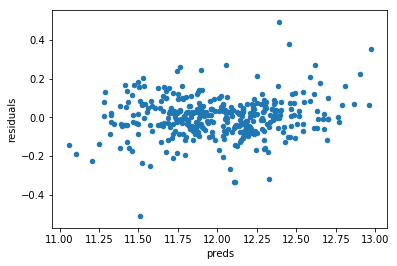

In [64]:
preds = pd.DataFrame({"preds":combined_pred, "true":y_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  if sys.path[0] == '':


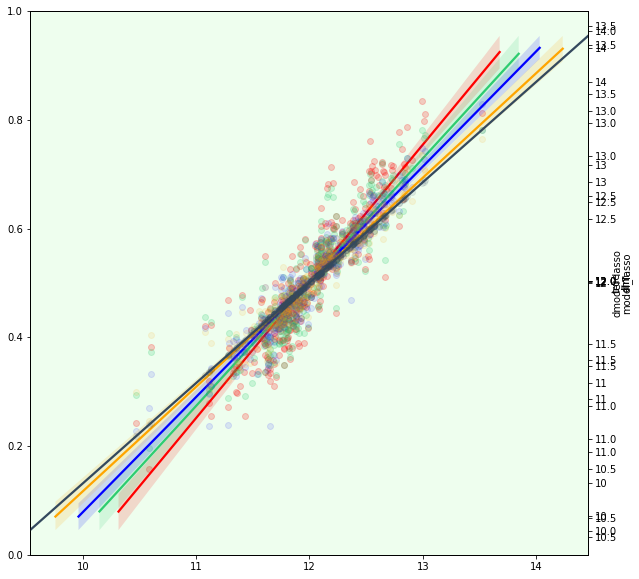

In [1093]:
all_preds = pd.DataFrame({#"preds": combined_pred,
                          "lm": lm.predict(X_test),
                          "model_lasso": model_lasso.predict(X_test),
                            "dlm": dlm_predict,
                            "dmodel_lasso": dmodel_lasso_predict,
#                           "model_xgb": model_xgb.predict(X_test),
#                           "elastic_net": elastic_net.predict(X_test),
#                           "bag_regressor": bag.predict(X_test),
                          "true":y_test
                         })
fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_bgcolor("#eefeee")
# sns.regplot(x='true', y='preds', data=all_preds, ax=ax, color="#95a5a6", scatter_kws={'alpha':.3})
ax2 = ax.twinx()
sns.regplot(x='true', y='lm', data=all_preds, ax=ax2, color="r", scatter_kws={'alpha':0.2})
ax3 = ax.twinx()
sns.regplot(x='true', y='model_lasso', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0.2})
ax2 = ax.twinx()
sns.regplot(x='true', y='dlm', data=all_preds, ax=ax2, color="b", scatter_kws={'alpha':0.1})
ax3 = ax.twinx()
sns.regplot(x='true', y='dmodel_lasso', data=all_preds, ax=ax3, color="orange", scatter_kws={'alpha':0.1})
# ax3 = ax.twinx()
# sns.regplot(x='true', y='bag_regressor', data=all_preds, ax=ax3, color="#2ecc71", scatter_kws={'alpha':0})

# ax4 = ax.twinx()
# sns.regplot(x='true', y='elastic_net', data=all_preds, ax=ax4, color="#3498db", scatter_kws={'alpha':0})

# ax5 = ax.twinx()
# sns.regplot(x='true', y='model_xgb', data=all_preds, ax=ax5, color="#FF69B4", scatter_kws={'alpha':.4})
ax6 = ax.twinx()
sns.regplot(x='true', y='true', data=all_preds, ax=ax6, color="#34495e", scatter_kws={'alpha': 0.1})

In [73]:
print(mean_absolute_error(y_test, combined_pred))
print(mean_absolute_error(y_test, elastic_net.predict(X_test)))
print(mean_absolute_error(y_test, model_lasso.predict(X_test)))
print(mean_absolute_error(y_test, model_xgb.predict(X_test)))
print(mean_absolute_error(y_test, lm.predict(X_test)))

0.07530413366151853
0.07828444201268202
0.07921988167186991
0.0854422582531566
0.08495947051515414


In [62]:
print(explained_variance_score(y_test, combined_pred))
print(explained_variance_score(y_test, elastic_net.predict(X_test)))
print(explained_variance_score(y_test, model_lasso.predict(X_test)))
print(explained_variance_score(y_test, model_xgb.predict(X_test)))

0.9283142307085968
0.9248232057787331
0.9221032348473697
0.9069201957865901


In [63]:
print(mean_squared_error(y_test, combined_pred))
print(mean_squared_error(y_test, elastic_net.predict(X_test)))
print(mean_squared_error(y_test, model_lasso.predict(X_test)))
print(mean_squared_error(y_test, model_xgb.predict(X_test)))

0.010853276675726952
0.011390469662362054
0.011788577840345375
0.014120293219261967


In [244]:
predictions_df = pd.DataFrame([model_lasso_predict, elastic_net_predict,
                               gboost_predict, model_xgb_predict,
                               lm_predict])
predictions_df = predictions_df.T.rename(index=str, columns = {0:"Lasso",
                                                               1:"ElasticNet",
                                                               2:"GradientBoost",
                                                               3:"XGB", 4:"LM" })
len(predictions_df)
predictions_df_stack = pd.DataFrame([model_lasso_predict_stack, elastic_net_predict_stack,
                                     gboost_predict_stack, model_xgb_predict_stack,
                                     lm_predict_stack])
predictions_df_stack = predictions_df_stack.T.rename(index=str, columns = {0:"Lasso",
                                                                           1:"ElasticNet",
                                                                           2:"GradientBoost",
                                                                           3:"XGB", 4:"LM" })
y_test1 = pd.DataFrame(y_test.reset_index()).drop("index", axis=1)["SalePrice"]
stack_gboost = GradientBoostingRegressor(n_estimators=2000)
stack_gboost.fit(predictions_df, y_test1)
# rf_stack = RandomForestRegressor(n_estimators=2000, max_depth=2).fit(predictions_df, y_test1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [194]:
# lm = LinearRegression().fit(predictions_df, y_test1)


# print(lm.score(predictions_df_stack, y_test_stack))
# print(rmse_cv_stack(lm, predictions_df_stack, y_test_stack).mean())

0.8005037908630646
0.132631237420204


In [218]:
# Calculate RMSE
def rmse_cv_stack(model, X, y):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)
print(stack_gboost.score(predictions_df_stack, y_test_stack))
print(rmse_cv_stack(stack_gboost, predictions_df_stack, y_test_stack).mean())

0.8724407189572899
0.1369813452012161


In [401]:
# PCA workflow not being used atm.

# pca = PCA()
# # scaled_data = scale(X_train.T)
# # pca.fit(scaled_data)    

# pca.fit(scale(X_train))
# pca_data = pca.transform(scale(X_train))

# per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
# labels = ["PC" + str(x) for x in range(1, len(per_var) + 1)]
# plt.bar(left=range(1,6), height=per_var[:5], tick_label=labels[:5])
# plt.show()

# pca_df = pd.DataFrame(pca_data)
# plt.scatter(pca_df[0], pca_df[1], pca_df[3], c=["red","blue","green"])

In [34]:
# le = LabelEncoder()
# le.fit(train["KitchenQual"])
# list(le.classes_)
# tdf = pd.DataFrame([le.transform(train["KitchenQual"]),
#                    train["KitchenQual"],
#                    train["SalePrice"]]).T
# tdf.rename(columns={0:"Encoded", 1:"Original", 2:"SalePrice"}, inplace=True)

In [9]:
# def ordinal_to_numeric(df):
#     for i in range(len(df.columns)-1):
#         is_cat = df.iloc[:,i].values.any() in ("Gd","Ex","TA","Fa","Po")
#         if is_cat == True:
#             df[df.columns[i]] = df[df.columns[i]].map({"Ex":5, "Gd":4, "TA":3, "Fa":2, "Po":1})
#     return df